In [1]:
import pandas as pd
import numpy as np
import os
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('./Softs/')
import Spanve
# print(Spanve.__version__)
from tqdm import trange
from sklearn.metrics import confusion_matrix, roc_auc_score

def evaluate(true, pred, score):
    tn, fp, fn, tp = confusion_matrix(true, pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    acc = (tp + tn) / (tp + tn + fp + fn)
    auc = roc_auc_score(true, score)
    return sensitivity, specificity, acc, auc

In [6]:
%%time
data_dir = './data/Simulation2/'
result = pd.DataFrame(columns = ['data','K','sensitivity', 'specificity', 'acc', 'auc'])

for dat in os.listdir(data_dir):
    # print(dat)
    dat_path = os.path.join(data_dir, dat)
    adata = sc.read_h5ad(dat_path)
    sc.pp.filter_genes(adata,min_counts=1)
    true = adata.var['gene_label'] != "-1"
    
    for K in [5, 10, 15, 20, None]:
        spmodel = Spanve.Spanve(adata, n_jobs=1, K=K, neighbor_finder= ('knn' if K else 'Delaunay'))
        spmodel.fit()
        pred = spmodel.rejects
        score = 1 - spmodel.pvals
        result.loc[len(result)] = dat, K, *evaluate(true, pred, score)

result['random_noise'] = result['data'].str.split('_').str[1]
result['dropout_noise'] = result['data'].str.split('_').str[2].str.replace('.h5ad','', regex =False)
result['K'] = result['K'].fillna('Delaunay')

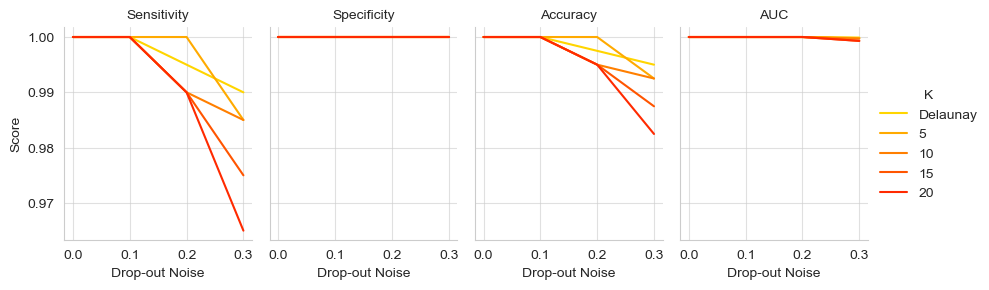

In [133]:
dfvis = (
    result
    .melt(value_vars=['sensitivity', 'specificity', 'acc', 'auc'], id_vars = ['data', 'random_noise','dropout_noise', 'K'], var_name = 'metric', value_name = 'score')
)
dfvis['K'] = dfvis['K'].astype(str)
g = sns.relplot(
    data=dfvis,
    hue="K", y='score', x = 'dropout_noise',
    col="metric", #hue="K", 
    kind="line", 
    palette='autumn_r',
    height=3, aspect=.75, 
    # errwidth = 1,
    hue_order = ['Delaunay','5','10','15','20'],
    errorbar=None, err_style = 'bars',
    # facet_kws = dict(sharex = False, sharey=True),
)
g.set_ylabels('Score')
g.set_xlabels('Drop-out Noise')
for i, ax in enumerate(g.axes.flatten()):
    ax.set_title(['Sensitivity', 'Specificity', 'Accuracy', 'AUC'][i], fontsize = 10)
# g.savefig('./Results/Sim_HyperParams_K.pdf', bbox_inches='tight')